<a href="https://colab.research.google.com/github/mikedaczar21/Fraud_Classifier/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [ ]:
!pip install transformers

In [56]:
!pip install shap

     |████████████████████████████████| 356 kB 10.8 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491639 sha256=16581fe2ff4536a2dde8e64bc8f522ee2abe30fc4ed90e7c12065b16acc03b13
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [68]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoConfig, AutoModelForSequenceClassification


# specify GPU
device = torch.device("cuda")

In [7]:
feature_path = "/content/Fraud_AL_Claims_5k_Model3_UK.xlsx"

# Load Dataset

In [9]:
df = pd.read_excel(feature_path )
df.head()

,Unnamed: 0,Unnamed: 0.1,claim_no,feature_no,aegis_claim_no,business_segment_ds,line_of_business_ds,subline_of_business_ds,Loss_Description,loss_loc_city_nm,loss_loc_state,loss_zip_cd,Loss_Date,Policy_Eff_Date,Policy_Exp_Date,Claim_Create_Date,claim_open_dt,latitude_ds,longitude_ds,fnol_fraud_score_ct,post_fnol_fraud_score_ct,loss_cause_ds,loss_nature_ds,scs_referral_status_ds,claim_status_cd,company_nm,policy_no,vehicle_reg_no,injury_body_part_cd,injury_body_part_ds,medical_paid_to_date_usd_am,total_paid_to_date_usd_am,reportdate_to_aig_dt,fnol_dt,policy_country_nm,insured_nm,insured_street_address1_nm,reserve_currency_nm,major_line_nm,Main_Cause,Sub_Cause,loss_loc_same_as_insured_cd,loss_loc_country_nm,claimant_same_as_insured_in,do_you_want_to_create_a_reserve,fatal_injury_in,economic_loss_details_ds,economic_damage_detail,claim_funded_ds,claim_vin,claim_vehicle_reg_no,claim_vehicle_year,claim_vehicle_make,claim_vehicle_model,feature_vehicle_registration_no,feature_vehicle_type_cd,feature_vehicle_make_nm,feature_vehicle_year_tx,feature_vin,Fraud Label,Investigate_Text,ONECLAIMCLAIMNUMBER,PYID,INSUREDLNAME,CLAIMANTNAME,reserve_currency_name,loss_loc_country,first_notice_loss_diff,policy_loss_diff,policy_end_diff,claim_policy_start_diff,claim_loss_diff,Fraud_Text
0,0,137,0017212372GB,0017212372GB-003,A09922221,Commercial Line,Casualty,Primary Auto,TP Vehicle Performing 'Emergency Stop' - third...,London,London,NaN,2019-11-25,2019-03-31,2020-03-30,2019-11-27 08:55:31.945,2019-12-02,NaN,NaN,0.0,0.0,UN - unknown,UN - Unknown,Not Referred,Resolved-Closed,LONDON-AMERICAN INTERNATIONAL GRP UK LTD,25523160,HY67GAU,5.0,Lower Back,0,0.00,2019-11-25,2019-11-25,GREAT BRITAIN,HOMESERVE PLC AND SUBSIDI,CABLE DRIVE,GBP,CASUALTY,Third Party Vehicle Struck in Rear by Insured ...,TP Vehicle Performing 'Emergency Stop',0.0,GB,NaN,Yes,N,NaN,NaN,NaN,NaN,HY67GAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Poss exag.,0017212372GB,A09922221,HOMESERVE PLC AND SUBSIDI,Jason Bailey,British Pound,United Kingdom,0,56.5,126,-241.371898,2.371898,third party vehicle struck in rear by insured ...
1,1,209,0022063594GB,0022063594GB-003,A09845595,Commercial Line,Casualty,Primary Auto,TP Vehicle Stationary - third party vehicle st...,NaN,NaN,NaN,2018-11-28,2018-03-01,2019-02-28,2018-12-05 09:54:52.542,2018-12-05,NaN,NaN,0.0,0.0,UN - unknown,UN - Unknown,Investigation Completed,Resolved-Closed,LONDON-AMERICAN INTERNATIONAL GRP UK LTD,23156,HV18MZY,2.0,Neck,0,4798.57,2018-11-30,2018-11-30,GREAT BRITAIN,CBRE GROUP INC,A,GBP,CASUALTY,Third Party Vehicle Struck in Rear by Insured ...,TP Vehicle Stationary,0.0,GB,NaN,Yes,N,NaN,NaN,None,NaN,HV18MZY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,LVI,NaN,NaN,NaN,NaN,British Pound,United Kingdom,2,90.0,92,-279.413108,7.413108,third party vehicle struck in rear by insured ...
2,2,428,0032746831GB,0032746831GB-003,A09797382,Commercial Line,Casualty,Primary Auto,third party vehicle struck in rear by insured ...,NaN,NaN,NaN,2018-05-19,2017-10-01,2018-09-30,2018-05-24 05:40:42.257,2018-05-24,NaN,NaN,0.0,0.0,NaN,NaN,Investigation Completed,Resolved-Closed,LONDON-UK CHARTIS,23003330,KO67OZX,5.0,Lower Back,0,66.44,2018-05-21,2018-05-21,GREAT BRITAIN,AVIS EUROPE LTD MAIN FLEE,AVIS HOUSE,GBP,EXCESS CASUALTY,Third Party Vehicle Struck in Rear by Insured ...,TP Vehicle Stationary,0.0,GB,N,Yes,N,NaN,NaN,None,NaN,KO67OZX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Case Closed,NaN,NaN,NaN,NaN,British Pound,United Kingdom,2,48.0,134,-235.236600,5.236600,third party vehicle struck in rear by insured ...
3,3,474,0034818589GB,0034818589GB-003,A09928473,Commercial Line,Casualty,Primary Auto,TP Vehicle Stationary - third party vehicle st...,DUNFERMLINE,NaN,NaN,2019-12-28,2019-01-01,2019-12-31,2020-01-02 11:31:46.849,2020-01-02,NaN,NaN,45.0,45.0,UN - unknown,UN - Unknown,Not Referred,Open,LONDON-AMERICAN INTERNATIONAL GRP UK LTD,7900,DW68FVM,2.0,Neck,0,6434.71,2019-12-30,2019-12-30,GREAT BRITAIN,EUROPCAR GROUP UK LTD AND,NaN,GBP,CASUALTY,Third Party Vehicle Struck in Rear by

In [10]:
text = df['Fraud_Text'] # features or inputs into model
labels = df['Fraud Label'] # labels

In [ ]:
df.shape

(5572, 2)

In [11]:
# check class distribution
df['Fraud Label'].value_counts(normalize = True)

1    0.946044
0    0.053956
Name: Fraud Label, dtype: float64

# Split train dataset into train, validation and test sets

In [15]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Fraud_Text'], df['Fraud Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Fraud Label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [122]:
train_list = list(train_text)
val_list = list(val_text)
test_list = list(test_text)

In [124]:
train_encodings = tokenizer(train_list, truncation=True, padding=True)
val_encodings = tokenizer(val_list, truncation=True, padding=True)
test_encodings = tokenizer(test_list, truncation=True, padding=True)

In [126]:
## PYTORCH CODE
import torch

class FraudData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FraudData(train_encodings, list(train_labels) )
val_dataset = FraudData(val_encodings, list(val_labels))
test_dataset = FraudData(test_encodings, list(test_labels))

# Import BERT Model and BERT Tokenizer

In [115]:
# import BERT-base pretrained model
bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
#config = AutoConfig.from_pretrained('bert-base-uncased')
#bert = AutoModel.from_config(config)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained('results/tokenizer/')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

('results/tokenizer/tokenizer_config.json',
 'results/tokenizer/special_tokens_map.json',
 'results/tokenizer/vocab.txt',
 'results/tokenizer/added_tokens.json',
 'results/tokenizer/tokenizer.json')

In [35]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [36]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

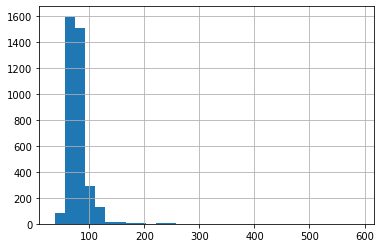

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [72]:
max_seq_len = 130

In [116]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


# Convert Integer Sequences to Tensors

In [117]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [118]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [85]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [103]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      
      self.config = AutoConfig.from_pretrained('bert-base-uncased')

      self.bert = AutoModelForSequenceClassification.from_config(self.config)
      

      # self.bert = AutoModelForSequenceClassification.from_config(config)
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      #_, cls_hs = self.bert(sent_id, attention_mask=mask)

      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [104]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [106]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [109]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[9.27020202 0.52850561]


In [110]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

# Fine-Tune BERT

In [82]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [45]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [111]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model   
    train_loss, _ = train()

                                          
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5


ValueError: ignored

In [33]:
epochs

10

# Load Saved Model

In [93]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [99]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [59]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.45      0.84      0.59        43
           1       0.99      0.94      0.96       744

    accuracy                           0.94       787
   macro avg       0.72      0.89      0.78       787
weighted avg       0.96      0.94      0.94       787



In [100]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.22      0.79      0.35        43
           1       0.99      0.84      0.91       744

    accuracy                           0.84       787
   macro avg       0.60      0.82      0.63       787
weighted avg       0.94      0.84      0.88       787



In [60]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,36,7
1,44,700


In [128]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset            # evaluation dataset
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "

RuntimeError: ignored

In [62]:

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import shap

In [137]:
from transformers import AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache 

In [139]:
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

RuntimeError: ignored

In [133]:

explainer = shap.Explainer(pred)

In [132]:
shap_values = explainer(df['Fraud_Text'][:3])

TypeError: ignored

In [ ]:
shap.plots.text(shap_values)